In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
from sklearn.preprocessing import StandardScaler

#PREPROCESSING

In [ ]:
data1 = pd.read_csv('Gula Konsumsi.csv')
data2 = pd.read_csv('Attributes (Imputed by Interpolation).csv')

NameError: name 'pd' is not defined

In [ ]:
data1.head()

In [ ]:
data2.head()

In [ ]:
datatrain = pd.concat([data1.iloc[:, [0]], data2.iloc[:, 1:], data1.iloc[:, 1:]], axis=1)
datatrain.head()

In [ ]:
datatrain.shape

In [ ]:
datatrain.info()

In [ ]:
datatrain.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
datatrain.describe()

In [ ]:
# Cek kolom mana yang memiliki nilai NaN
kolom_dengan_nan = datatrain.columns[datatrain.isna().sum() > 0].tolist()

In [ ]:
# Pastikan hanya memilih kolom numerik (float)
kolom_numerik_dengan_nan = [col for col in kolom_dengan_nan if datatrain[col].dtype in ['float64', 'int64']]

In [ ]:
# Pastikan ada kolom yang perlu diimputasi
if not kolom_numerik_dengan_nan:
    raise ValueError("Tidak ada kolom numerik dengan NaN untuk diimputasi.")

In [ ]:
# Dictionary untuk menyimpan hasil imputasi
imputed_values = {}

# Loop untuk setiap kolom dengan NaN
for kolom in kolom_numerik_dengan_nan:
    print(f"Mengimputasi kolom: {kolom}")

    with pm.Model():
        mu = pm.Normal("mu", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)

        # Data yang tersedia (tidak NaN)
        observed = pm.Normal("observed", mu=mu, sigma=sigma,
                             observed=datatrain[kolom][datatrain[kolom].notna()])

        # Variabel untuk data yang hilang (NaN)
        missing_values = pm.Normal("missing_values", mu=mu, sigma=sigma,
                                   shape=int(datatrain[kolom].isna().sum()))  # ✅ FIX: Konversi ke int Python

        # Sampling
        trace = pm.sample(1000, return_inferencedata=True)

    # Mengambil  edian dari distribusi posterior sebagai imputasi
    imputed_values[kolom] = trace.posterior["missing_values"]. median(dim=("chain", "draw")).values

    # Mengisi nilai NaN dalam DataFrame dengan hasil imputasi
    datatrain.loc[datatrain[kolom].isna(), kolom] = imputed_values[kolom]

print("✅ Semua nilai NaN telah diimputasi menggunakan PyMC!")

In [ ]:
datatrain.isna().sum()

In [ ]:
datatrain.to_csv("gulakonsumsi_imputed.csv", index=False)

#Iterasi 1: R2

In [ ]:
df = pd.read_csv('gulakonsumsi_imputed.csv')

In [ ]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to /tmp/pip-install-ko2ojo2g/granite-tsfm_8eeb301bf4aa46c2be855b4a9b3c285b
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-ko2ojo2g/granite-tsfm_8eeb301bf4aa46c2be855b4a9b3c285b
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [ ]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

# Results dir
OUT_DIR = "/content/hasil"

In [ ]:
from sklearn.preprocessing import StandardScaler  # Import StandardScaler

# Dataset
timestamp_column = "Date"  # Change to 'Date'
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ['Aceh', 'Bali', 'Banten', 'Bengkulu',
       'DI Yogyakarta', 'DKI Jakarta', 'Gorontalo', 'Jambi', 'Jawa Barat',
       'Jawa Tengah', 'Jawa Timur', 'Kalimantan Barat', 'Kalimantan Selatan',
       'Kalimantan Tengah', 'Kalimantan Timur', 'Kalimantan Utara',
       'Kepulauan Bangka Belitung', 'Kepulauan Riau', 'Lampung',
       'Maluku Utara', 'Maluku', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
       'Papua Barat', 'Papua', 'Riau', 'Sulawesi Barat', 'Sulawesi Selatan',
       'Sulawesi Tengah', 'Sulawesi Tenggara', 'Sulawesi Utara',
       'Sumatera Barat', 'Sumatera Selatan', 'Sumatera Utara']
split_config = {
    "train": [0, int(0.7 * len(df))],
    "valid": [int(0.7 * len(df)), int(0.85 * len(df))],
    "test": [int(0.85 * len(df)), len(df)]
}

# Preprocessing
# Exclude 'Date' column from features to scale
features_to_scale = df.columns.difference(target_columns + [timestamp_column]) # Changed 'date' to timestamp_column

scaler = StandardScaler()
scaler.fit(df.iloc[split_config["train"][0]:split_config["train"][1]][features_to_scale])

df[features_to_scale] = scaler.transform(df[features_to_scale])

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": ['USDIDR Close', 'Price Crude Oil', 'Change % Crude Oil',
       'Price Natural Gas', 'Change % Natural Gas', 'Price Newcastle Coal',
       'Change % Newcastle Coal', 'Price Palm Oil', 'Change % Palm Oil',
       'Price US Sugar', 'Change % US Sugar', 'Price US Wheat',
       'Change % US Wheat'],
}

INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.272259920835495, 'eval_model_preparation_time': 0.0038, 'eval_runtime': 3.366, 'eval_samples_per_second': 16.637, 'eval_steps_per_second': 0.297}
(56, 96, 47)
(56, 47, 8, 192)


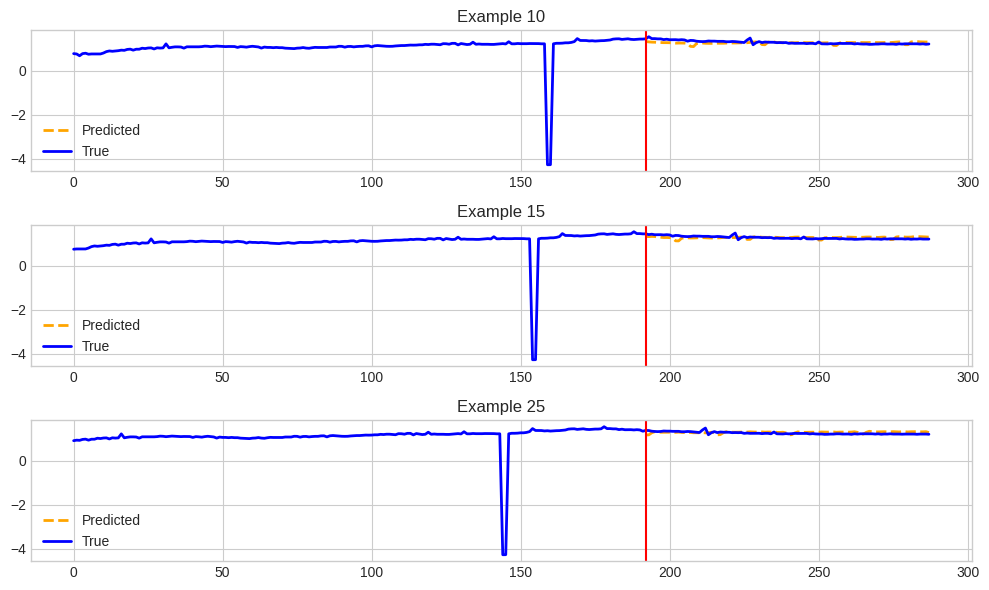

In [ ]:
###Zeroshot eceran

dataset_name=TARGET_DATASET
context_length=CONTEXT_LENGTH
forecast_length=PREDICTION_LENGTH
batch_size=64

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)


# Load model
zeroshot_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    freq_prefix_tuning=None,
    #freq=None,
    #prefer_l1_loss=False,
    #prefer_longer_context=True,
)

dset_train, dset_valid, dset_test = get_datasets(tsp, df, split_config)

temp_dir = tempfile.mkdtemp()

# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=batch_size,
        seed=SEED,
        report_to="none",
    ),
)

# evaluate = zero-shot performance
print("+" * 20, "Test MSE zero-shot", "+" * 20)
zeroshot_output = zeroshot_trainer.evaluate(dset_test)
print(zeroshot_output)


# get predictions

predictions_dict = zeroshot_trainer.predict(dset_test)

predictions_np = predictions_dict.predictions[0]

print(predictions_np.shape)


# get backbone embeddings (if needed for further analysis)

backbone_embedding = predictions_dict.predictions[1]

print(backbone_embedding.shape)

# plot
plot_predictions(
    model=zeroshot_trainer.model,
    dset=dset_test,
    plot_dir=os.path.join(OUT_DIR, dataset_name),
    plot_prefix="test_zeroshot",
    indices=[10, 15, 25],
    #indices = [i for i in [685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015] if test_start <= i < test_end],
    channel=0,
)

#return dset_test, test_indices
dset_test = pd.DataFrame([sample for sample in dset_test])
dset_test.to_csv("dset_test.csv", index=False)

In [ ]:
import torch

# Simpan model
model_path = "zeroshot_model.pt"
torch.save(zeroshot_model.state_dict(), model_path)

print(f"Model disimpan sebagai {model_path}")


import pickle

# Simpan model sebagai pickle
model_path = "zeroshot_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(zeroshot_model, f)

print(f"Model disimpan sebagai {model_path}")

In [ ]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=10,  # Meningkatkan jumlah few-shot data dari 5% ke 10%
    freeze_backbone=False,  # Tidak membekukan backbone agar model bisa belajar lebih baik
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    # OUT_DIR = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset
    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
    print("✅ TimeSeriesPreprocessor initialized")


    dset_train, dset_val, dset_test = get_datasets(
        tsp, df, split_config, fewshot_fraction=fewshot_percent / 100, fewshot_location="first"
    )

    finetune_forecast_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
        loss=loss,
        quantile=quantile,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")

    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(OUT_DIR, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(OUT_DIR, "logs"),
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        seed=SEED,
    )

    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,
        early_stopping_threshold=1e-5,
    )
    tracking_callback = TrackingCallback()

    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )
    # ✅ Save model and preprocessor after training
    save_path = os.path.join(OUT_DIR, "fine_tuned_model")
    os.makedirs(save_path, exist_ok=True)

    finetune_forecast_trainer.model.save_pretrained(save_path)

    # Simpan konfigurasi preprocessor ke dalam JSON
    import json

    tsp_config = {
        "timestamp_column": tsp.timestamp_column,
        "id_columns": tsp.id_columns,
        "target_columns": tsp.target_columns,
        "control_columns": tsp.control_columns,
        "context_length": tsp.context_length,
        "prediction_length": tsp.prediction_length,
        "scaling": tsp.scaling,
        "encode_categorical": tsp.encode_categorical,
        "scaler_type": tsp.scaler_type,
    }

    with open(os.path.join(save_path, "preprocessor.json"), "w") as f:
        json.dump(tsp_config, f, indent=4)

    print(f"✅ Preprocessor configuration saved at: {save_path}/preprocessor.json")


    return finetune_forecast_trainer, tsp  # Return trainer for later use

trainer, tsp = fewshot_finetune_eval(
    dataset_name="harga_komoditas",
    batch_size=64,
    context_length=512,
    forecast_length=96,
    fewshot_percent=10,
    freeze_backbone=False,  # Jangan dibekukan agar bisa belajar lebih baik
    num_epochs=10,  # Tambah jumlah epoch untuk hasil lebih optimal
    learning_rate=1e-4,  # Set manual untuk stabilitas
    )


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 10% --------------------
✅ TimeSeriesPreprocessor initialized


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.0001


Epoch,Training Loss,Validation Loss
1,0.275300,0.255975
2,0.324900,0.255042
3,0.241000,0.252796
4,0.209900,0.250444
5,0.196600,0.248561
6,0.221600,0.247332
7,0.206100,0.246682
8,0.190600,0.246395
9,0.181800,0.246320
10,0.197800,0.246320


[TrackingCallback] Mean Epoch Time = 0.482906436920166 seconds, Total Train Time = 22.22112226486206
++++++++++++++++++++ Test MSE after few-shot 10% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.2734663784503937, 'eval_runtime': 1.5685, 'eval_samples_per_second': 35.703, 'eval_steps_per_second': 0.638, 'epoch': 10.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(56, 96, 47)
(56, 47, 8, 192)


IndexError: list index out of range

In [ ]:

import json
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=10,
    freeze_backbone=False,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep
    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
    print("✅ TimeSeriesPreprocessor initialized")

    # Ambil dataset dengan validasi
    dset_train, dset_val, dset_test = get_datasets(
        tsp, df, split_config, fewshot_fraction=fewshot_percent / 100, fewshot_location="first"
    )

    if len(dset_test) == 0:
        raise ValueError("❌ Dataset test kosong setelah few-shot sampling. Coba turunkan 'fewshot_percent'.")

    print(f"Dataset train: {len(dset_train)}, val: {len(dset_val)}, test: {len(dset_test)}")

    # Model setup
    finetune_forecast_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
        loss=loss,
        quantile=quantile,
    )

    if freeze_backbone:
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(finetune_forecast_model, dset_train, batch_size)
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")

    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(OUT_DIR, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(OUT_DIR, "logs"),
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        seed=SEED,
    )

    early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=10, early_stopping_threshold=1e-5)
    tracking_callback = TrackingCallback()

    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=max(1, math.ceil(len(dset_train) / batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine-tune model
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)
    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)

    # Cek prediksi sebelum diproses
    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    if not predictions_dict.predictions:
        raise ValueError("❌ Prediksi kosong, pastikan dataset memiliki cukup sampel.")

    predictions_np = predictions_dict.predictions[0]
    print("Prediction shape:", predictions_np.shape)

    # Handle jika backbone embedding tidak ada
    if len(predictions_dict.predictions) > 1:
        backbone_embedding = predictions_dict.predictions[1]
        print("Backbone embedding shape:", backbone_embedding.shape)
    else:
        print("⚠️ Backbone embedding tidak tersedia.")

    # Validasi index sebelum plotting
    valid_indices = [i for i in [685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015] if i < len(dset_test)]

    if valid_indices:
        plot_predictions(
            model=finetune_forecast_trainer.model,
            dset=dset_test,
            plot_dir=os.path.join(OUT_DIR, dataset_name),
            plot_prefix="test_fewshot",
            indices=valid_indices,
            channel=0,
        )
    else:
        print("⚠️ Tidak ada indeks valid untuk plotting.")

    # Simpan model
    save_path = os.path.join(OUT_DIR, "fine_tuned_model")
    os.makedirs(save_path, exist_ok=True)
    finetune_forecast_trainer.model.save_pretrained(save_path)

    # Simpan preprocessor
    tsp_config = {
        "timestamp_column": tsp.timestamp_column,
        "id_columns": tsp.id_columns,
        "target_columns": tsp.target_columns,
        "control_columns": tsp.control_columns,
        "context_length": tsp.context_length,
        "prediction_length": tsp.prediction_length,
        "scaling": tsp.scaling,
        "encode_categorical": tsp.encode_categorical,
        "scaler_type": tsp.scaler_type,
    }
    with open(os.path.join(save_path, "preprocessor.json"), "w") as f:
        json.dump(tsp_config, f, indent=4)

    print(f"✅ Preprocessor configuration saved at: {save_path}/preprocessor.json")

    return finetune_forecast_trainer, tsp

# Panggil fungsi dengan parameter yang sama
trainer, tsp = fewshot_finetune_eval(
    dataset_name="harga_komoditas",
    batch_size=64,
    context_length=512,
    forecast_length=96,
    fewshot_percent=10,
    freeze_backbone=False,
    num_epochs=10,
    learning_rate=1e-4,
)


-------------------- Running few-shot 10% --------------------
✅ TimeSeriesPreprocessor initialized


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2


Dataset train: 1, val: 56, test: 56


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


Using learning rate = 0.0001


Epoch,Training Loss,Validation Loss
1,0.275300,0.255975
2,0.324900,0.255042
3,0.241000,0.252796
4,0.209900,0.250444
5,0.196600,0.248561
6,0.221600,0.247332
7,0.206100,0.246682
8,0.190600,0.246395
9,0.181800,0.246320
10,0.197800,0.246320


[TrackingCallback] Mean Epoch Time = 0.4950645923614502 seconds, Total Train Time = 23.184314012527466
++++++++++++++++++++ Test MSE after few-shot 10% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.2734663784503937, 'eval_runtime': 1.8995, 'eval_samples_per_second': 29.481, 'eval_steps_per_second': 0.526, 'epoch': 10.0}
Prediction shape: (56, 96, 47)
Backbone embedding shape: (56, 47, 8, 192)
⚠️ Tidak ada indeks valid untuk plotting.
✅ Preprocessor configuration saved at: /content/hasil/fine_tuned_model/preprocessor.json


INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:/usr/local/lib/python3.11/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.272259920835495, 'eval_model_preparation_time': 0.0046, 'eval_runtime': 2.8356, 'eval_samples_per_second': 19.749, 'eval_steps_per_second': 0.353}
(56, 96, 47)
(56, 47, 8, 192)


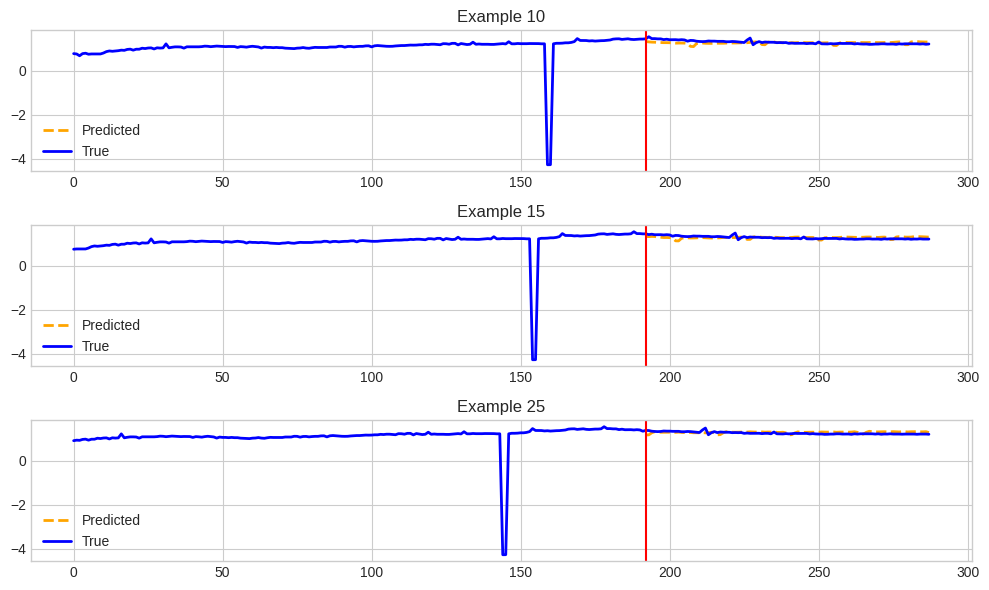

In [ ]:
zeroshot_eval(dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

#ITERASI 2: DFM

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
import matplotlib.pyplot as plt

In [ ]:
# Load dataset (pastikan data memiliki kolom 'tanggal', 'provinsi', dan harga pangan yang relevan)
df = pd.read_csv("gulakonsumsi_imputed.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

In [ ]:
# Normalisasi data (opsional)
df = (df - df.mean()) / df.std()

In [ ]:
# Definisikan model DFM
n_factors = 1  # Jumlah faktor laten
lags = 2        # Lag dalam model
model = DynamicFactor(df, k_factors=n_factors, factor_order=lags)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# Estimasi model
fit = model.fit()
print(fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                                                                                                                                                                                                                                                                                                                                                                                                             Statespace Model Results                                                                                                                                                                                                                                                                                                                                                                                                                                             
Dep. Variable:     ['USDIDR Close', 'Price Crude Oil', 'Change % Crude Oil', 'Price Natural Gas', 'Change % Natural G

In [ ]:
# Prediksi harga pangan
forecast_steps = 30  # Misalnya, prediksi 30 hari ke depan
pred = fit.get_prediction(start=-forecast_steps, dynamic=True)
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps, freq='D')
forecast_values = pred.predicted_mean

#ITERASI 3: DFM

In [ ]:
% Tambahkan path untuk fungsi dan data
addpath 'mutils/functions'
addpath 'dfm-matlab/functions'
addpath(genpath('mutils/toolbox'))

SyntaxError: invalid syntax (<ipython-input-7-b947589a7dc6>, line 2)

#ITERASI 4: GARCH

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 10.9 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
# Load the data
data = pd.read_csv("cabai_rawit.csv")

In [3]:
data.head()

,Date,Aceh,Bali,Banten,Bengkulu,DI Yogyakarta,DKI Jakarta,Gorontalo,Jambi,Jawa Barat,...,Price Natural Gas,Change % Natural Gas,Price Newcastle Coal,Change % Newcastle Coal,Price Palm Oil,Change % Palm Oil,Price US Sugar,Change % US Sugar,Price US Wheat,Change % US Wheat
0,2022-01-01,46940.634665,76680.0,80020.0,43040.0,63490.0,98730.0,64110.0,51740.0,91430.0,...,3.995255,-27.948558,-125.386821,-436.985875,6.601437,3.357832,18.446574,0.916577,662.463126,-24.536968
1,2022-01-02,45847.524303,74370.0,81700.0,45830.0,64110.0,98730.0,63440.0,59810.0,93530.0,...,4.031116,-5.028045,57.687037,-156.300483,6.592109,2.630141,18.454580,0.170590,722.150195,-10.285339
2,2022-01-03,43551.354072,72660.0,84630.0,53330.0,70680.0,97420.0,67340.0,66470.0,86060.0,...,3.678000,3.400000,157.500000,-7.130000,5.259000,1.940000,18.740000,-0.740000,758.000000,-1.650000
3,2022-01-04,54860.573939,75000.0,88680.0,53840.0,69670.0,95730.0,63990.0,65410.0,88960.0,...,3.582000,-2.610000,174.100000,10.540000,5.308000,0.930000,18.750000,0.050000,770.000000,1.580000
4,2022-01-05,50000.000000,70020.0,79400.0,53840.0,63250.0,88960.0,62670.0,64750.0,87970.0,...,3.710000,3.570000,179.900000,3.330000,5.437000,2.430000,18.340000,-2.190000,760.750000,-1.200000


In [4]:
# Menentukan urutan kolom yang diinginkan
ordered_columns = [
    "Date", "USDIDR Close", "Price Crude Oil", "Change % Crude Oil", "Price Natural Gas", "Change % Natural Gas",
    "Price Newcastle Coal", "Change % Newcastle Coal", "Price Palm Oil", "Change % Palm Oil", "Price US Sugar",
    "Change % US Sugar", "Price US Wheat", "Change % US Wheat", "Aceh", "Bali", "Banten", "Bengkulu",
    "DI Yogyakarta", "DKI Jakarta", "Gorontalo", "Jambi", "Jawa Barat", "Jawa Tengah", "Jawa Timur",
    "Kalimantan Barat", "Kalimantan Selatan", "Kalimantan Tengah", "Kalimantan Timur", "Kalimantan Utara",
    "Kepulauan Bangka Belitung", "Kepulauan Riau", "Lampung", "Maluku Utara", "Maluku", "Nusa Tenggara Barat",
    "Nusa Tenggara Timur", "Papua Barat", "Papua", "Riau", "Sulawesi Barat", "Sulawesi Selatan", "Sulawesi Tengah",
    "Sulawesi Tenggara", "Sulawesi Utara", "Sumatera Barat", "Sumatera Selatan", "Sumatera Utara"
]
# Menyesuaikan DataFrame dengan urutan baru
data = data[ordered_columns]

In [5]:
data['Date'] = pd.to_datetime(data['Date']) # Change the format to '%d/%m/%Y'
data.set_index('Date', inplace=True)

In [6]:
# Extract time features
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek

In [7]:
# Define features and target variables
target_columns = ['Aceh', 'Bali', 'Banten', 'Bengkulu',
       'DI Yogyakarta', 'DKI Jakarta', 'Gorontalo', 'Jambi', 'Jawa Barat',
       'Jawa Tengah', 'Jawa Timur', 'Kalimantan Barat', 'Kalimantan Selatan',
       'Kalimantan Tengah', 'Kalimantan Timur', 'Kalimantan Utara',
       'Kepulauan Bangka Belitung', 'Kepulauan Riau', 'Lampung',
       'Maluku Utara', 'Maluku', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
       'Papua Barat', 'Papua', 'Riau', 'Sulawesi Barat', 'Sulawesi Selatan',
       'Sulawesi Tengah', 'Sulawesi Tenggara', 'Sulawesi Utara',
       'Sumatera Barat', 'Sumatera Selatan', 'Sumatera Utara']

In [8]:
X = data.drop(columns=target_columns)
y = data[target_columns]

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Train a multi-output regression model
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [11]:
# Predict
predictions = model.predict(X_test)

In [12]:
# Evaluate model
mae = mean_absolute_error(y_test, predictions, multioutput='raw_values')
mape = mean_absolute_percentage_error(y_test, predictions)
print("Mean Absolute Error per province:", mae)
print("Mean Absolute Percentage Error per province:", mape)

Mean Absolute Error per province: [7695.35698501 3919.7722511  3901.12293374 3276.52263239 4233.32360185
 3992.63045904 4859.12562607 3099.33166725 3594.80444128 3691.74395702
 3763.93881154 2841.43051781 3577.18439637 3043.37356767 3866.43145106
 4549.10500671 5231.51157213 3734.81549393 2481.44729705 3670.79235767
 4612.83027365 3763.59236503 1921.96955382 4151.5702378  4009.01156418
 4290.59717961 2861.41539585 2156.9554215  2589.67036253 3015.70432048
 4355.54955495 4724.08651258 3268.80702855 5491.97034802]
Mean Absolute Percentage Error per province: 0.07207703511971673


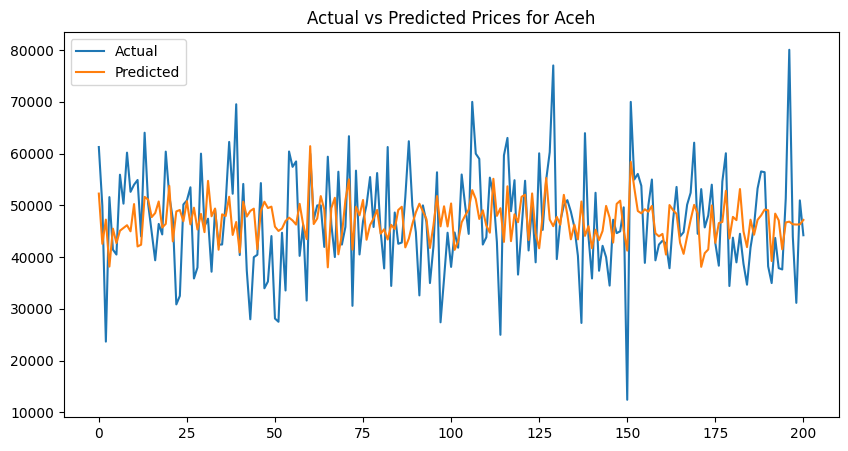

In [13]:
# Plot actual vs predicted for a sample province
plt.figure(figsize=(10,5))
plt.plot(y_test.iloc[:, 0].values, label='Actual')
plt.plot(predictions[:, 0], label='Predicted')
plt.legend()
plt.title(f"Actual vs Predicted Prices for {target_columns[0]}")
plt.show()

In [14]:
# Load dataset testing
test_data = pd.read_csv("merged_dataset_interpolated1 - merged_dataset_interpolated1 (1).csv")

# Pastikan kolom Date ada dan dalam format datetime
test_data['Date'] = pd.to_datetime(test_data['Date'], dayfirst=True)

In [15]:
test_data.head()

,Date,USDIDR Close,Price Crude Oil,Change % Crude Oil,Price Natural Gas,Change % Natural Gas,Price Newcastle Coal,Change % Newcastle Coal,Price Palm Oil,Change % Palm Oil,Price US Sugar,Change % US Sugar,Price US Wheat,Change % US Wheat
0,2024-10-01,15.195000,69.390000,2.390000,3.288000,-1.700000,141.65000,-2.380000,4166.000000,1.020000,22.970000,1.320000,599.000000,2.570000
1,2024-10-02,15.260000,69.690000,0.430000,3.297000,0.270000,140.25000,-0.990000,4305.000000,3.340000,22.680000,-1.260000,615.250000,2.710000
2,2024-10-03,15.415000,73.170000,4.990000,3.369000,2.180000,140.80000,0.390000,4267.000000,-0.880000,23.240000,2.470000,603.500000,-1.910000
3,2024-10-04,15.480000,73.680000,0.700000,3.305000,-1.900000,148.20000,5.260000,4400.000000,3.120000,23.010000,-0.990000,589.750000,-2.280000
4,2024-10-05,15.860271,74.410291,1.999549,2.885286,-16.989323,150.68326,3.475454,4471.735921,1.053665,21.376932,-0.952866,584.760602,-1.988848


In [16]:
#Extract time-based features
test_data['year'] = test_data['Date'].dt.year
test_data['month'] = test_data['Date'].dt.month
test_data['day'] = test_data['Date'].dt.day
test_data['dayofweek'] = test_data['Date'].dt.dayofweek

# Gunakan hanya fitur waktu untuk prediksi (sesuai dengan model yang telah dilatih)
X_test_new = test_data[X_train.columns]

# Lakukan prediksi
predictions_test = model.predict(X_test_new)

# Simpan hasil prediksi dalam DataFrame
predictions_df = pd.DataFrame(predictions_test, columns=target_columns)
predictions_df.insert(0, 'Date', test_data['Date'])

In [17]:
# Simpan hasil prediksi ke CSV
predictions_df.to_csv("prediksicabairawit.csv", index=False)

# Tampilkan hasil prediksi
print(predictions_df.head())

        Date          Aceh          Bali        Banten      Bengkulu  \
0 2024-10-01  48102.351990  39434.499250  51602.229538  43707.145640   
1 2024-10-02  46527.073250  40509.636692  51966.676000  44167.868359   
2 2024-10-03  50179.085963  36974.766230  45476.600000  42868.945640   
3 2024-10-04  48324.526623  39024.856411  54157.044828  43871.464227   
4 2024-10-05  48441.420920  40373.918970  54481.644828  44399.422820   

   DI Yogyakarta   DKI Jakarta     Gorontalo         Jambi    Jawa Barat  ...  \
0   33992.900000  55830.200000  72892.600000  47641.800000  50424.400000  ...   
1   34625.800000  55632.500000  75723.536519  49451.800000  49250.100000  ...   
2   33753.125391  50312.600000  68185.800000  44468.069159  48625.628443  ...   
3   35594.597735  58575.403527  68492.300000  49025.871964  51773.539919  ...   
4   35761.919888  60053.964879  78179.756553  50221.871964  51611.700000  ...   

          Papua          Riau  Sulawesi Barat  Sulawesi Selatan  \
0  84561.0000

In [26]:
data = pd.read_csv("sample_submission.csv")
# Mengubah kolom B menjadi float
data['price'] = data['price'].astype(float)

print(data.dtypes)  # Mengecek tipe data setelah konversi

ValueError: could not convert string to float: '18.000.363.316.423.200'